In [4]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter


# Fetching the data from the JSON files

In [5]:
import os
import json

# Specify the path to the folder containing JSON files
data_folder_path = '../data/'

# Create an empty dictionary to store data
all_data = {}

# Iterate over all files in the folder
for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        # Form the complete path to the JSON file
        json_file_path = os.path.join(data_folder_path, filename)
        
        # Read the JSON file and store its content in the dictionary
        with open(json_file_path, 'r') as file:
            # Use the filename (without extension) as the key in the dictionary
            all_data[os.path.splitext(filename)[0]] = json.load(file)

# Evolving directed graph with nodes as characters and weighted edges
For this part, the network to be constructed is of all the characters appearing in all 3 seasons of the Naruto anime. In the following, a function will be defined such that there is a network for each episode with a total of 1013 episodes and hence 1013 graphs. The networks are constructed in such a way, that for the first episode, all the appearing characters will be the nodes in the graph. The links between the nodes, simply represents that the characters appeared in the same episode. The next graph will build upon the first graph, such that for subsequent episodes, if new characters appear, these will be new nodes. These will only link to the characters appearing in the same episode and not for any of the previous characters from the previous graph, if they do not appear for the next episodes. If characters co-occur several times in episodes, a weight of 1 will be added to their edge for each time they co-occur. Hence the resulting graphs are based on co-occurence and therefore quickly become dense and is inevitabely a giant connected component as no character appears by themselves. 

In [6]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    graph_dict = {}  # Initialize an empty dictionary to store graphs
    count = 1  # Initializing a count

    # Loop over every season
    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  # Create a new directed graph for each episode
                characters = episodes_data[i]["Characters"]  # Characters from each episode as a list

                # Add nodes from the previous graph (if it exists). Control statement for the first graph
                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)

                    # Add edges and update weights from the previous graph
                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                # Add new characters as nodes
                if characters is not None:  # Control statement if the list of characters is empty/None type
                    G.add_nodes_from(characters)  # Adding the characters

                    # Add weighted edges for characters appearing in the same episode
                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
                count += 1  # Updating the count

    else:
        # Initialize graph and graph dict to append the graphs
        season_data = data[season]  
        graph_dict = {}  # Initialize an empty dictionary to store graphs
        count = 1  # Initializing a count

        # Loop over every episode
        for i in range(len(season_data)):
            G = nx.Graph()  # Create a new directed graph for each episode
            characters = season_data[i]["Characters"]  # Characters from each episode as a list

            # Add nodes from the previous graph (if it exists). Control statement for the first graph
            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)
                
                # Add edges and update weights from the previous graph
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            # Add new characters as nodes
            if characters is not None:  # Control statement if the list of characters is empty/None type
                G.add_nodes_from(characters)  # Adding the characters

                # Add weighted edges for characters appearing in the same episode
                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
            count += 1  # Updating the count

    # Add node attributes to all graphs
    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict

# Adding the note attributes from the characters' infobox.
def add_node_attributes(graph, attributes_dict):
    for node, attributes in attributes_dict.items():
        # Normalize the node name
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        # Check if the normalized node exists in the graph
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

## Retrieving the 1013 graphs from all the episodes as a dictionary
Some of the characters are provided with an 'information box' which is a table containing some attributes for the characters. These differ for each character along with the amount of attributes are listed. The characters provided with an information box, get the attributes added to their nodes. The nodes are colored according to which village they belong to in the Naruto anime. There is the "Five great nations" which have been chosen to be regarded as the most prominent villages in the series. Hence there are 5 different colors if a character is informed to belong to any of these and otherwise colored grey if they either do not belong to the 5 villages, or have not been provided with a village information.

In [7]:
# The dictionary of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters"], characters_info=all_data['characters_infobox'])

In [8]:
# The five great nations
five_great_node_dict = {
    "Konohagakure": "red",  # Set the color for Konohagakure to white
    "Sunagakure": "green",      # Set the color for other villages as needed
    "Kirigakure": "blue",
    "Kumogakure": "yellow",
    "Iwagakure": "#8B4513",
    "default": "black"
}

five_great_edges_dict = {
    "Konohagakure-Konohagakure": "red", 
    "Sunagakure-Sunagakure": "green", 
    "Kirigakure-Kirigakure": "blue", 
    "Kumogakure-Kumogakure": "yellow",
    "Iwagakure-Iwagakure": "#8B4513",
    "default": "gray"
}

id_color_dict = {"Konohagakure": "Red", "Sunagakure": "Green", "Kirigakure": "Blue", "Kumogakure": "Yellow", "Iwagakure": "Brown", "Remaining villages": "Black"}


In [9]:
def color_nodes_by_affiliation(G, node_colors_dict):
    """
    Color nodes in the graph based on their affiliation.

    Parameters:
    - G: NetworkX graph
    - node_colors_dict: Dictionary mapping village names to colors

    Returns:
    - List of node colors
    """
    node_colors = []
    for node in G.nodes:
        affiliation = G.nodes[node].get('Affiliation', [])

        if affiliation:
            for village in affiliation:
                if village in node_colors_dict:
                    node_colors.append(node_colors_dict[village])
                    break  # Stop checking other villages for this node
            else:
                node_colors.append(node_colors_dict["default"])  # Assign default color if no matching village is found
        else:
            node_colors.append(node_colors_dict["default"])

    return node_colors


def color_edges_by_affiliation(G, edge_colors_dict):
    """
    Color edges in the graph based on the affiliation of their nodes.

    Parameters:
    - G: NetworkX graph
    - edge_colors_dict: Dictionary mapping village names to edge colors

    Returns:
    - List of edge colors
    """
    edge_colors = []
    for edge in G.edges:
        node1, node2 = edge
        affiliation1 = G.nodes[node1].get('Affiliation', [])
        affiliation2 = G.nodes[node2].get('Affiliation', [])

        # Check if both nodes have affiliation
        if affiliation1 and affiliation2:
            common_affiliation = set(affiliation1) & set(affiliation2)
            if common_affiliation:
                for village in common_affiliation:
                    edge_key = f"{village}-{village}"
                    if edge_key in edge_colors_dict:
                        edge_colors.append(edge_colors_dict[edge_key])
                        break  # Stop checking other villages for this edge
                else:
                    edge_colors.append(edge_colors_dict["default"])  # Assign default color if no matching village is found
            else:
                edge_colors.append(edge_colors_dict["default"])  # Assign default color if no common affiliation
        else:
            edge_colors.append(edge_colors_dict["default"])  # Assign default color if one or both nodes have no affiliation

    return edge_colors

## Checking for which episode, that there are 'enough' characters introducted, such that the network starts to follow a power law distribution

At 22 episode already, is there enough characters introduced such that from episode 1-22 the degree distribution is in the 'random regime' and afterwards it switches over to an ultra small world regime where the power law exponent is below 3. 

In [10]:
for network in graph_dict_all_seasons:
    degrees_dict = dict(graph_dict_all_seasons[network].degree())
    degree = list(degrees_dict.values())

    degree_fit = powerlaw.Fit(degree)

    degree_exponent = degree_fit.alpha
    if degree_exponent < 3:
        print("No longer power-law distribution at episode", network)
        print("The degree exponent is", round(degree_exponent,4))
        break

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


## Drawing the resulting graph of all episodes

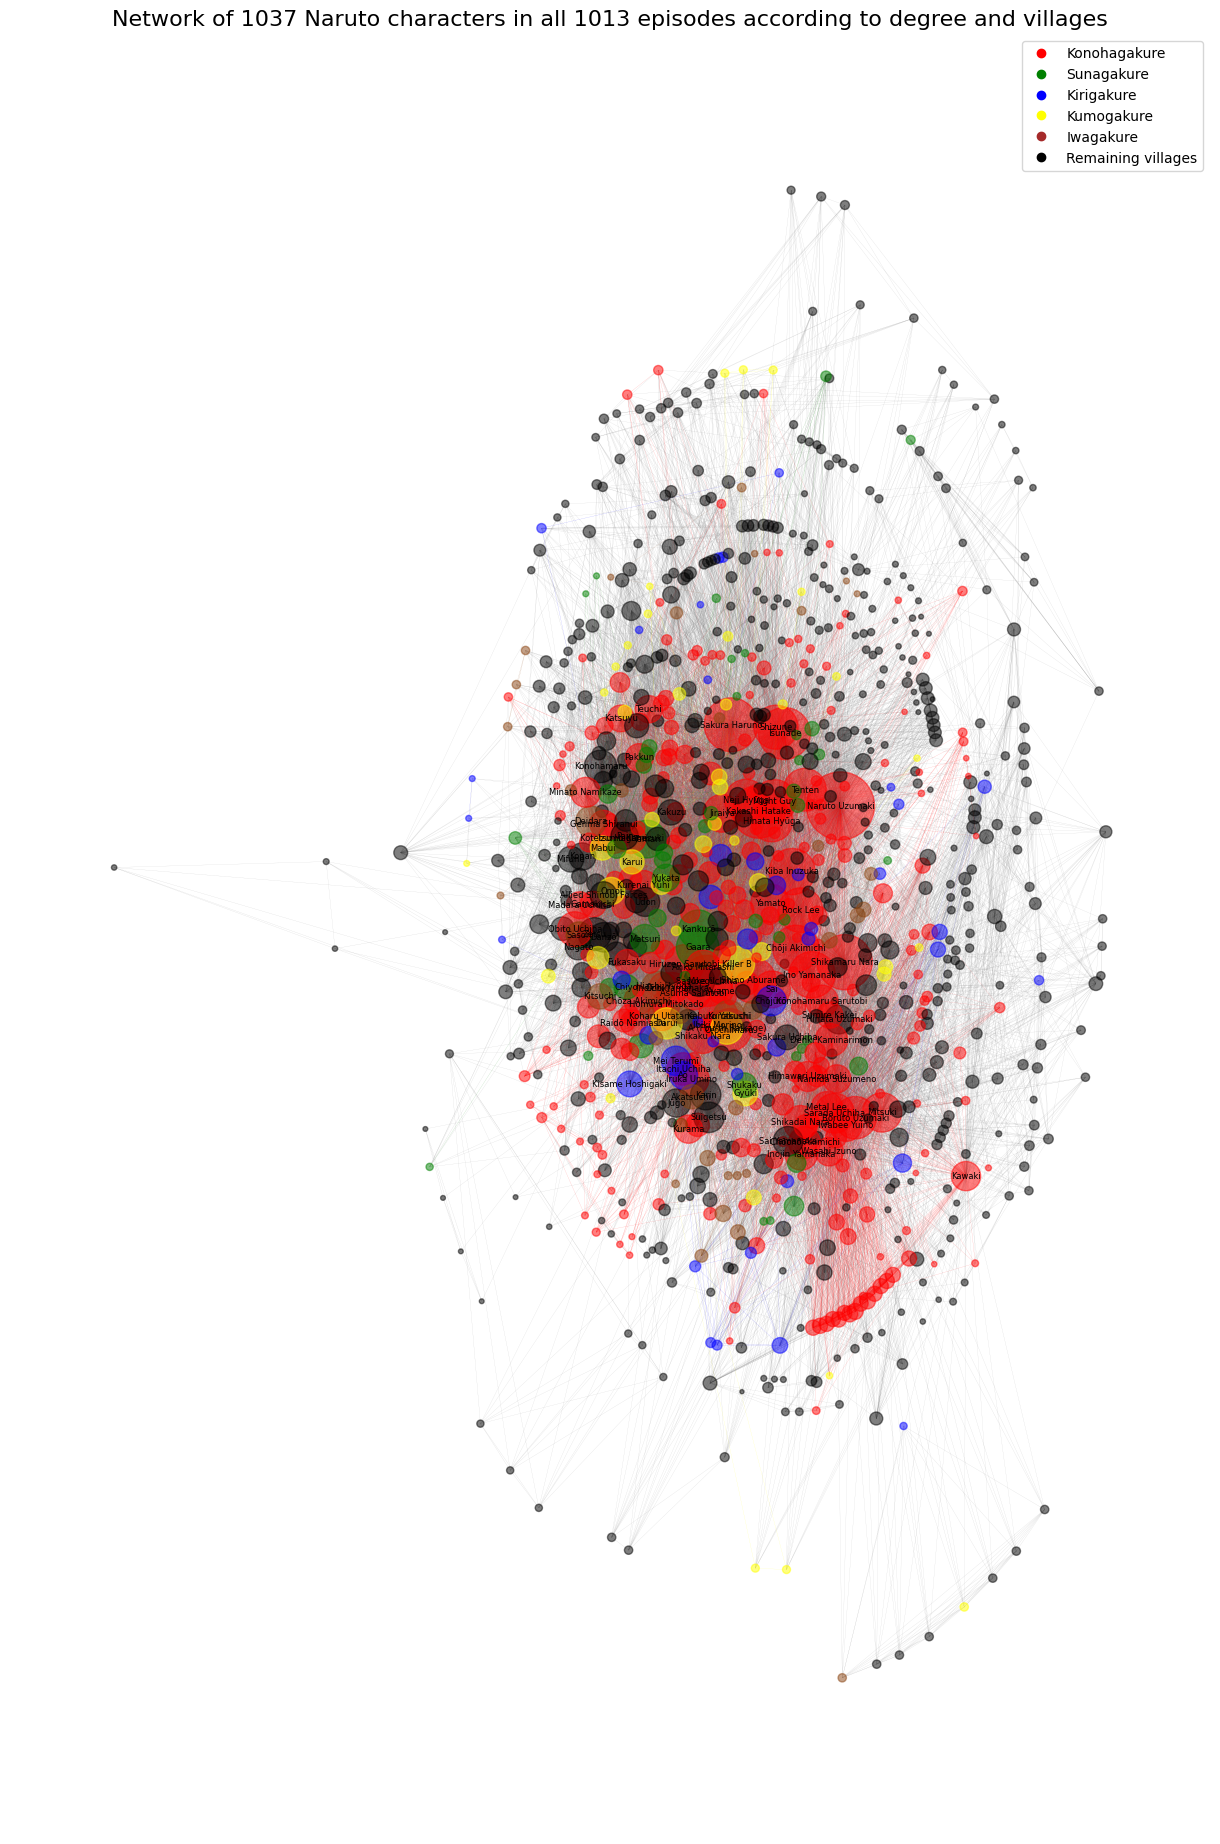

In [35]:
G1 = graph_dict_all_seasons['G1013']
degree_dictG1 = dict(G1.degree())

# Get node colors based on affiliation
node_colors = color_nodes_by_affiliation(G1, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G1, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))
pos = nx.kamada_kawai_layout(G1, scale=8.0)
node_sizes = [v * 3 for v in degree_dictG1.values()]
selected_nodes = [node for node, degree in degree_dictG1.items() if degree > 100]

markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

nx.draw(G1, pos, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G1, pos, {node: node for node in selected_nodes}, font_size=6)
plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 1037 Naruto characters in all 1013 episodes according to degree and villages", fontsize=16)
plt.show()

## Drawing the graph from episode 1-22

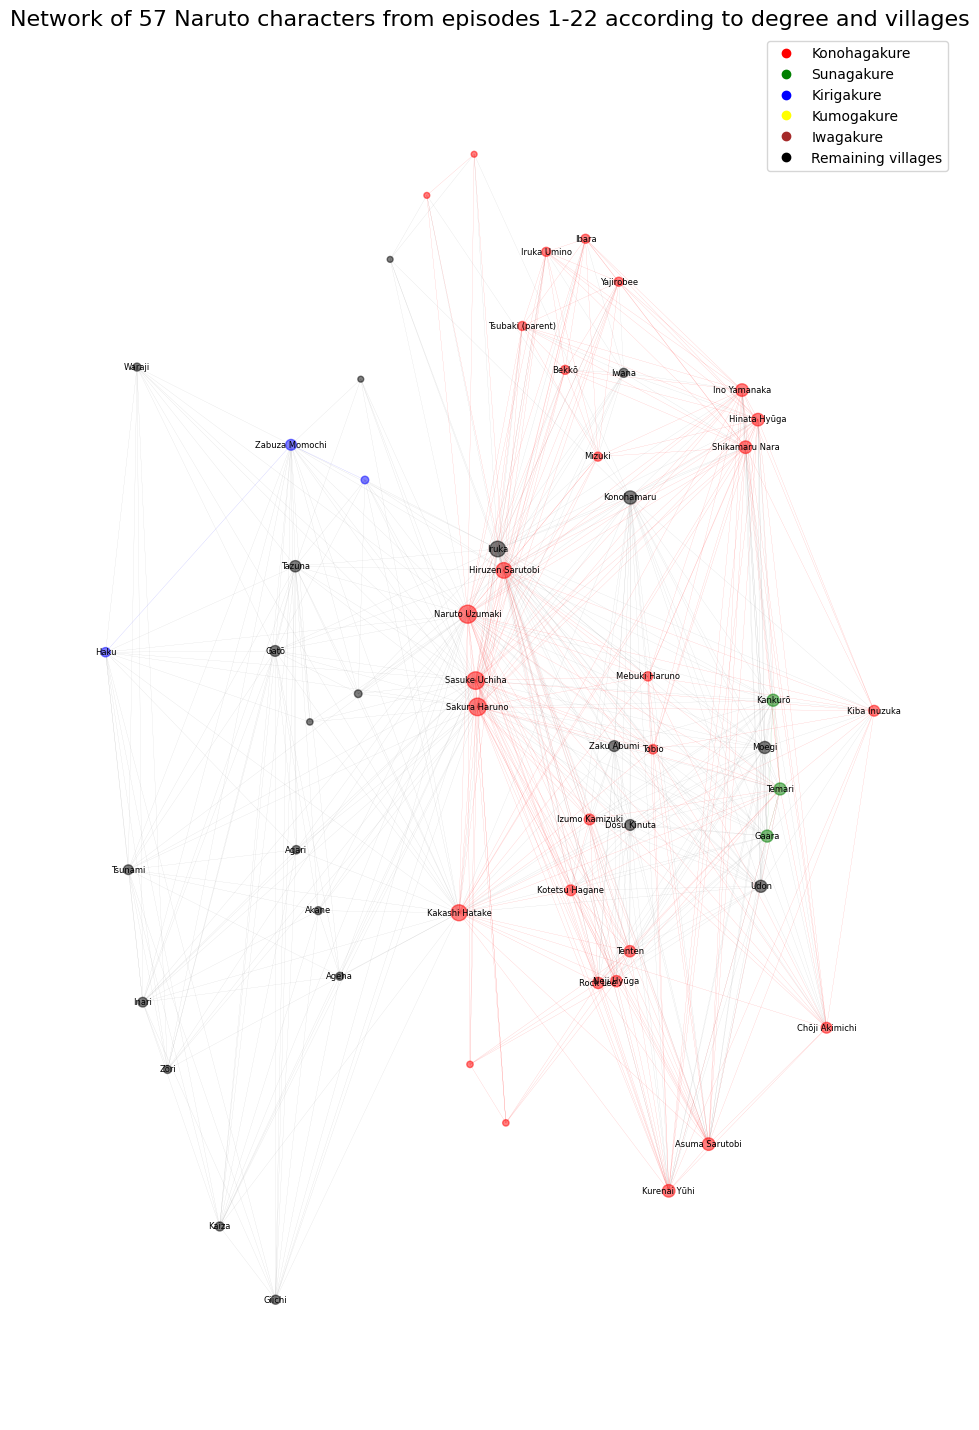

In [33]:
G22 = graph_dict_all_seasons['G22']
degree_dictG22 = dict(G22.degree())

# Get node colors based on affiliation
node_colors = color_nodes_by_affiliation(G22, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G22, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))

pos = nx.kamada_kawai_layout(G22, scale=8.0)
node_sizes = [v * 3 for v in degree_dictG22.values()]
selected_nodes = [node for node, degree in degree_dictG22.items() if degree > 10]
labels = {node: node for node in selected_nodes}
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 57 Naruto characters from episodes 1-22 according to degree and villages", fontsize=16)
nx.draw(G22, pos, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G22, pos, labels, font_size=6)  
plt.show()

In [12]:
def filter_edges_below_threshold(graph, threshold):
    # Create a copy of the graph to avoid modifying the original graph
    filtered_graph = graph.copy()

    # Iterate through edges and remove those below the threshold
    edges_to_remove = [(u, v) for u, v, w in graph.edges(data='weight') if w < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    # Identify isolated nodes and remove them
    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

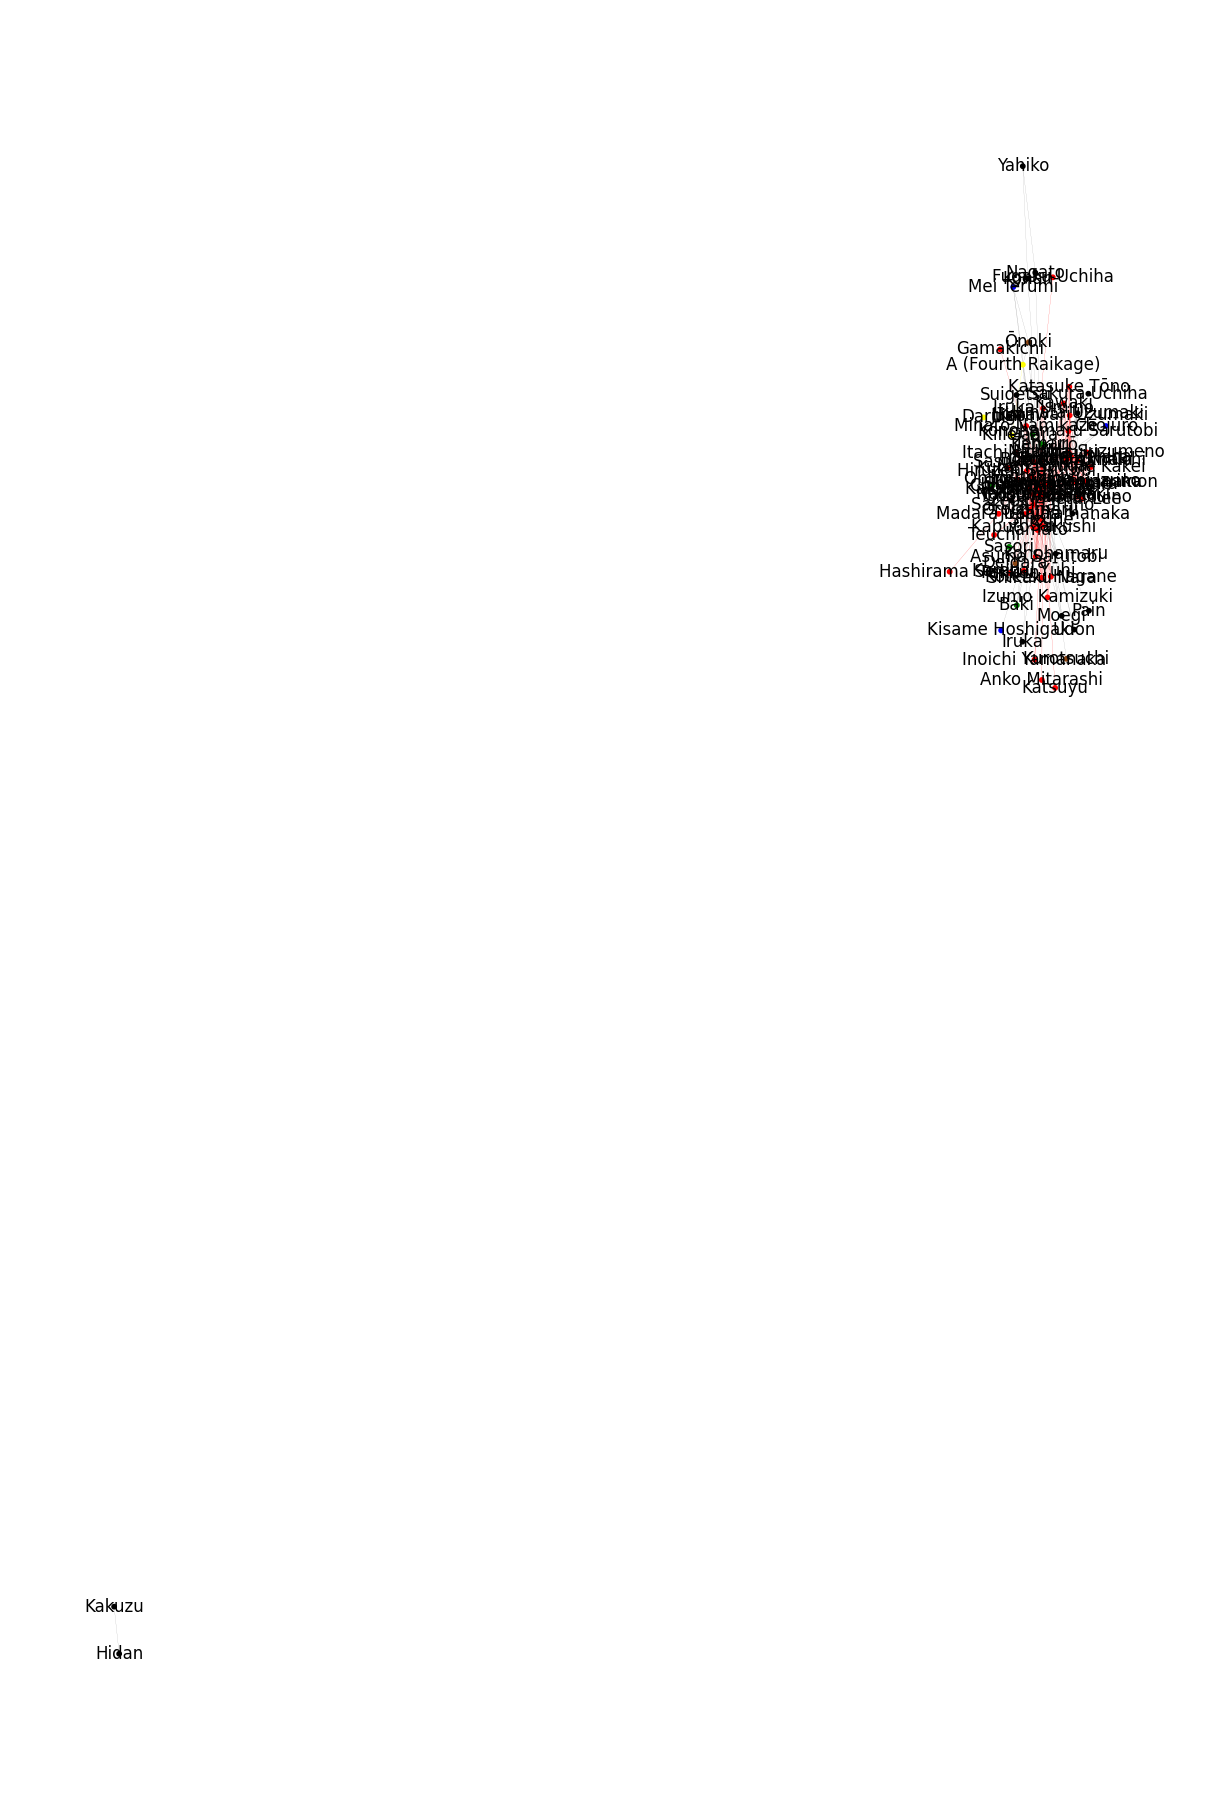

In [13]:
G1013_filtered = filter_edges_below_threshold(graph_dict_all_seasons['G1013'], 50)

node_colors = color_nodes_by_affiliation(G1013_filtered, five_great_node_dict)
edge_colors = color_edges_by_affiliation(G1013_filtered, five_great_edges_dict)

plt.figure(figsize=(12, 18))
pos = nx.spring_layout(G1013_filtered, scale=8.0)  
nx.draw(G1013_filtered, pos, node_size= 10, node_color=node_colors, edge_color=edge_colors, width=0.1, with_labels=True)




# Network properties and statistics

## - Degree distribution for the first 2 seaons

-------------------------------------------

In [14]:
def degree_distribution(graph_dict_all_seasons, episode):
    # Getting the graph from the episode and dictionary
    key = f'G{episode}'
    G = graph_dict_all_seasons[key]

    degrees = list(dict(G.degree()).values()) # Getting the degrees

    # Defining the values for the loglog plot for the degrees
    # Allocating list for the frequency/count of each degree
    frequency = []

    # Making a list of the unique degrees values in the network
    deg_unique = np.unique(degrees)

    # Counting the frequency for each degree
    for degree in deg_unique:
        count = degrees.count(degree)
        frequency.append(count)

    return degrees, frequency

In [15]:
degrees20, frequency20 = degree_distribution(graph_dict_all_seasons, 20)
degree_fit = powerlaw.Fit(degrees_20)
degree_exponent = degree_fit.alpha

print("The degree exponent for the degree distribution is:", round(degree_exponent,4))

NameError: name 'degrees_20' is not defined

-------------------------------------------

In [ ]:
# Fetching the dictionaries from season 1 and season 2 respectively
season1 = all_data["episodes_seasons_characters"]["Naruto: Original"] 
season2 = all_data["episodes_seasons_characters"]["Naruto: Shipp\u016bden"]

# Filtering the dictionaries such that season 1 and season 2 merge
keys_to_keep = ['Naruto: Original',"Naruto: Shipp\u016bden"]
filtered_dict_12 = {key: all_data["episodes_seasons_characters"][key] for key in keys_to_keep if key in all_data['episodes_seasons_characters']}

# The dictionary of 720 graphs for first season and for first + second season respectively
graphs_dict_season12 = create_character_interaction_graph(filtered_dict_12)

# --------------------------------------

In [ ]:
# Getting the last graph (720) for both seasons and extracting the degrees as a list
G20 = graphs_dict_season12["G20"]
degrees_20 = list(dict(G20.degree()).values())

In [ ]:
# Setting the limits for the axis of the distribution plot
# x-axis
min_x_lim = -5
max_x_lim = 50

# y-axis
min_y_lim = 0
max_y_lim = 60

In [ ]:
# Defining the values for the loglog plot for the degrees
# Allocating list for the frequency/count of each degree
frequency = []

# Making a list of the unique degrees values in the network
deg_unique = np.unique(degrees_20)

# Counting the frequency for each degree
for degree in deg_unique:
    count = degrees_20.count(degree)
    frequency.append(count)

Text(0, 0.5, 'Number of nodes (characters)')

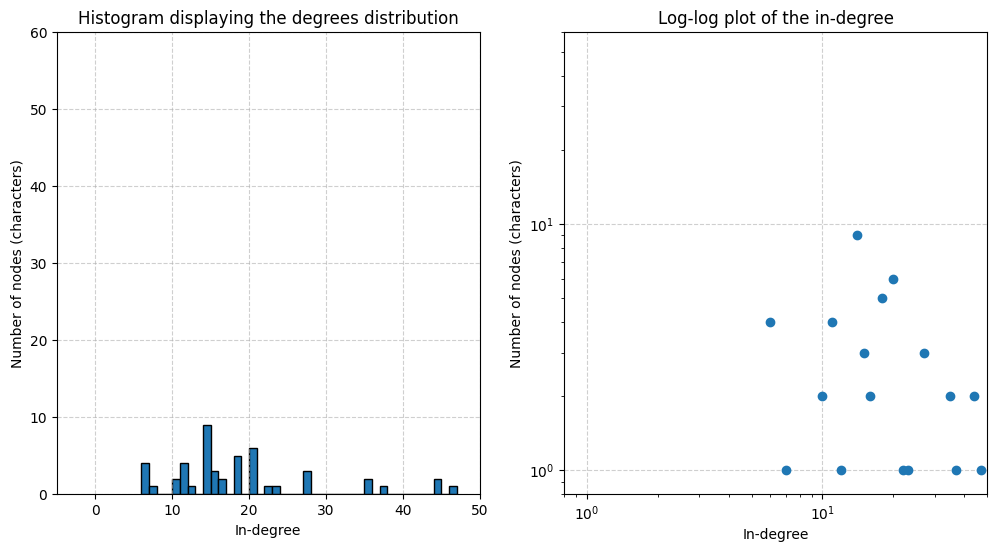

In [ ]:
plt.figure(figsize=(12, 6))
############################################## For the histograms ##########################################################
plt.subplot(1, 2, 1)
plt.hist(degrees_20, bins = range(min(degrees_20), max(degrees_20) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title("Histogram displaying the degrees distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

############################################## For the loglog plot ##########################################################
plt.subplot(1, 2, 2)
plt.loglog(deg_unique, frequency, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the in-degree")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

# ---------------------------------------

In [ ]:
# Getting the last graph (720) for both seasons and extracting the degrees as a list
G720 = graphs_dict_season12["G720"]
degrees_720 = list(dict(G720.degree()).values())

In [ ]:
# Setting the limits for the axis of the distribution plot
# x-axis
min_x_lim = min(degrees_720) - 10
max_x_lim = max(degrees_720) + 5

# y-axis
min_y_lim = 0
max_y_lim = 60

In [ ]:
# Defining the values for the loglog plot for the degrees
# Allocating list for the frequency/count of each degree
frequency = []

# Making a list of the unique degrees values in the network
deg_unique = np.unique(degrees_720)

# Counting the frequency for each degree
for degree in deg_unique:
    count = degrees_720.count(degree)
    frequency.append(count)

Text(0, 0.5, 'Number of nodes (characters)')

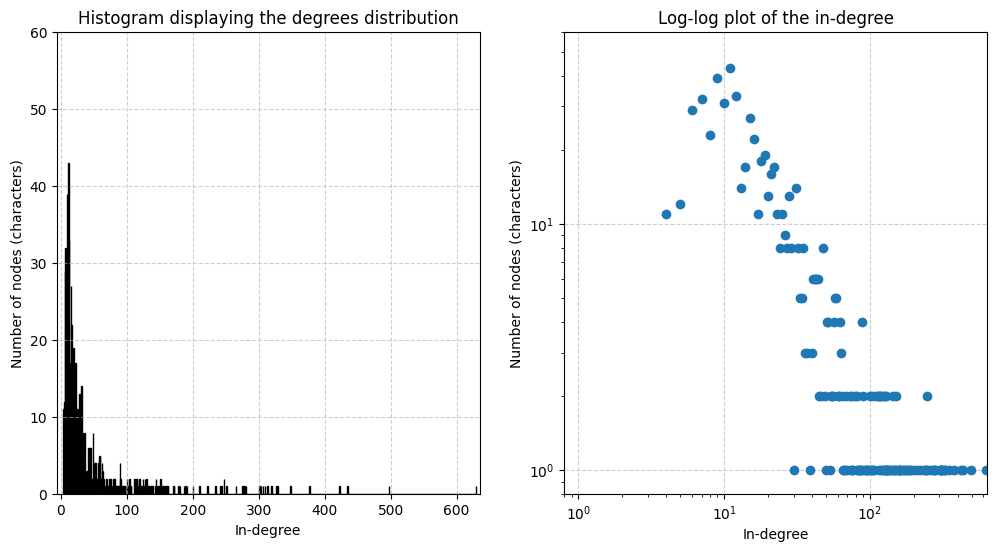

In [ ]:
plt.figure(figsize=(12, 6))
############################################## For the histograms ##########################################################
plt.subplot(1, 2, 1)
plt.hist(degrees_720, bins = range(min(degrees_720), max(degrees_720) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title("Histogram displaying the degrees distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

############################################## For the loglog plot ##########################################################
plt.subplot(1, 2, 2)
plt.loglog(deg_unique, frequency, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the in-degree")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

In [ ]:
# Extracting the exponent
degree_fit = powerlaw.Fit(degrees_720)
degree_exponent = degree_fit.alpha

print("The degree exponent for the degree distribution is:", round(degree_exponent,4))

Calculating best minimal value for power law fit
The degree exponent for the degree distribution is: 1.9642


------------------------------------------